In [1]:
import os, sys

sys.path.append(os.path.abspath(os.path.join("../..")))  # access sibling directories

from src.python.helpers import get_var_from_time_to_threshold

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from src.python.settings import plotting_settings, plotting_update
plt.rcParams.update(plotting_update)
import os
import pandas as pd
from collections import OrderedDict
from ipywidgets import interact
import cartopy.crs as ccrs

2024-05-08 15:21:27.250681: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/ho/programs/anaconda3/envs/bfdev-sensitivity/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
DIR = '/home/ho/code/climate/sim-data/preproc'
#DIR = '../../data/climate/preprocessed-climate-simulations-and-observations/'
filename_berkeley = 'observations-berkeley-new2024.nc'

In [3]:
X = xr.open_dataset(f'{DIR}/tas_anual_preproc_ssp370_ACCESS-ESM1-5.nc')
X

<xarray.Dataset>
Dimensions:       (ensemble: 1, member: 10, year: 251, latitude: 72,
                   longitude: 144)
Coordinates:
  * year          (year) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
  * latitude      (latitude) float64 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * longitude     (longitude) float64 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * member        (member) int64 0 1 2 3 4 5 6 7 8 9
  * ensemble      (ensemble) object 'ACCESS-ESM1-5|ssp370|0'
Data variables:
    TAS           (ensemble, member, year, latitude, longitude) float32 ...
    AREA          (latitude, longitude) float64 ...
    TAS_global    (ensemble, member, year) float64 ...
    TAS_baseline  (latitude, longitude) float32 ...
    pass_11       (ensemble) int64 ...
    pass_15       (ensemble) int64 ...
    pass_20       (ensemble) int64 ...
    pass_30       (ensemble) int64 ...
Attributes:
    description:  Coupled Climate Model Simulation ACCESS-ESM1-5, in scenario...

In [4]:
obs = xr.open_dataset(os.path.join(DIR, filename_berkeley))
obs

<xarray.Dataset>
Dimensions:       (longitude: 144, latitude: 72, month_number: 12, year: 174)
Coordinates:
  * longitude     (longitude) float64 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * latitude      (latitude) float64 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * month_number  (month_number) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * year          (year) int64 1850 1851 1852 1853 1854 ... 2020 2021 2022 2023
Data variables:
    land_mask     (latitude, longitude) float64 ...
    climatology   (month_number, latitude, longitude) float32 ...
    TAS           (year, month_number, latitude, longitude) float64 ...
    AREA          (latitude, longitude) float64 ...
    TAS_global    (year, month_number) float64 ...
    TAS_baseline  (latitude, longitude) float64 ...
Attributes:
    description:  Berkeley Earth Surface Temperature Project

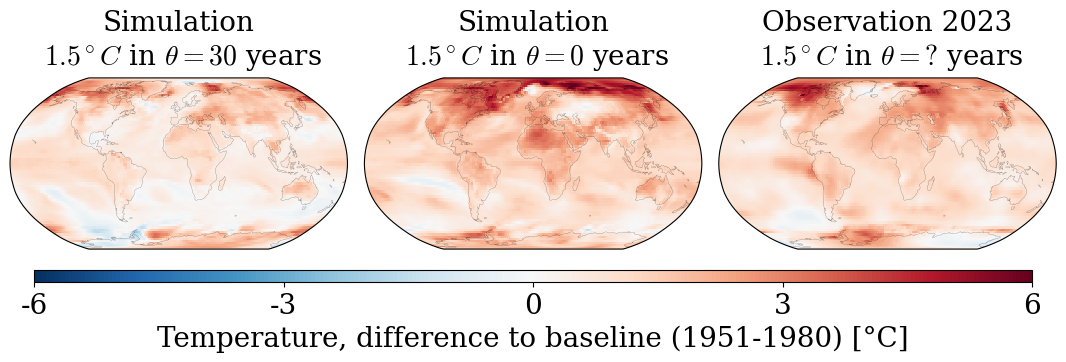

In [5]:
data_source = ['ACCESS_30', 'ACCESS_0', 'obs']#, 'CESM2']

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=len(data_source), figsize=(4.5*len(data_source), 2.7*1),
                         subplot_kw={'projection': ccrs.Robinson(central_longitude=0.0)},)


# Placeholder for maximum and minimum values for the shared colorbar
dat_min = float("inf")
dat_max = float("-inf")

subplot_dicts = []

for i, source in enumerate(data_source):
    if source == 'obs':
        data = obs.TAS.sel(year=2023).mean(dim='month_number')-obs.TAS_baseline
        #title = 'Observation 2023\n $\\theta_{1.5^\circ C}=?$ years'
        title = 'Observation 2023\n $1.5^\circ C$ in $\\theta=?$ years'
    elif source[:6] == 'ACCESS':
        tau = int(source.split('_')[1])
        data = (get_var_from_time_to_threshold(X, 'TAS', 1.5, tau).isel(ensemble=0).sel(member=i+4)-X.TAS_baseline)
        tau_string = r'$\theta'
        degree_string = r'$1.5^\circ C'
        title = f"Simulation\n {degree_string}$ in {tau_string}={tau}$ years"

    dat_min = min(dat_min, data.min())
    dat_max = max(dat_max, data.max())


    subplot_dicts.append({'data': data, 'title': title})

abs_max = max(abs(dat_min), abs(dat_max))

vmin, vmax = -abs_max, abs_max
#vmin, vmax = dat_min, dat_max

for i, source in enumerate(data_source):
    ax = axes.flatten()[i]
    data = subplot_dicts[i]['data']
    title = subplot_dicts[i]['title']
    ax.set_global()
    ax.coastlines(linewidth=0.1)
    img = data.plot(
        ax=ax, add_colorbar=False,
        transform=ccrs.PlateCarree(), vmin=vmin.round(0), vmax=vmax.round(0), cmap='RdBu_r'
    )
    ax.set_title(title, fontsize=20, pad=10)

#fig.suptitle('Global Mean Temperature Anomaly - 10 years before passing 1.5°C threshold')

# Add a shared colorbar to the figure
#cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])

plt.subplots_adjust(wspace=0.05)

cbar_ticks = np.linspace(vmin.round(0), vmax.round(0), 5)

cbar = fig.colorbar(img, location='bottom', ax=axes, ticks=cbar_ticks, fraction=0.06, pad=0.1, aspect=80,)
cbar.ax.set_xticklabels(cbar_ticks.round(0).astype(np.int32), fontsize=20)
cbar.ax.set_xlabel('Temperature, difference to baseline (1951-1980) [°C]', fontsize=20)


fig.savefig('figures/temp_maps.pdf', dpi=300, bbox_inches='tight')

